In [1]:
'''
Построение двухслойной нейронный сети для классификации цветков ириса
'''

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from sklearn.model_selection import train_test_split

In [2]:
### Шаг 1. Определение функций, которые понадобяться для обучения
# преобразование массива в бинарный вид результатов
def to_one_hot(Y):
    n_col = np.amax(Y) + 1
    binarized = np.zeros((len(Y), n_col))
    for i in range(len(Y)):
        binarized[i, Y[i]] = 1.
    return binarized

# преобразование массива в необходимый вид
def from_one_hot(Y):
    arr = np.zeros((len(Y), 1))

    for i in range(len(Y)):
        l = layer2[i]
        for j in range(len(l)):
            if(l[j] == 1):
                arr[i] = j+1
    return arr

# сигмоида и ее производная
def sigmoid(x):
    return 1/(1+np.exp(-x))

def sigmoid_deriv(x):
    return sigmoid(x)*(1 - sigmoid(x))

# нормализация массива
def normalize(X, axis=-1, order=2):
    l2 = np.atleast_1d(np.linalg.norm(X, order, axis))
    l2[l2 == 0] = 1
    return X / np.expand_dims(l2, axis)

In [3]:
### Шаг 2. Подготовка тренировочных данных
# получения данных из csv файла. укажите здесь путь к файлу Iris.csv
iris_data = pd.read_csv("Iris.csv")
print(iris_data.head()) # расскоментируйте, чтобы посмотреть структуру данных

# репрезентация данных в виде графиков
# g = sns.pairplot(iris_data.drop("Id", axis=1), hue="Species")
# plt.show() # расскоментируйте, чтобы посмотреть

# замена текстовых значений на цифровые
iris_data['Species'].replace(['Iris-setosa', 'Iris-virginica', 'Iris-versicolor'], [0, 1, 2], inplace=True)

# формирование входных данных
columns = ['SepalLengthCm', 'SepalWidthCm', 'PetalLengthCm', 'PetalWidthCm']
x = pd.DataFrame(iris_data, columns=columns)
x = normalize(x.values)

# формирование выходных данных(результатов)
columns = ['Species']
y = pd.DataFrame(iris_data, columns=columns)
y = y.values
y = y.flatten()
y = to_one_hot(y)

# Разделение данных на тренировочные и тестовые
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.33)

   Id  SepalLengthCm  SepalWidthCm  PetalLengthCm  PetalWidthCm      Species
0   1            5.1           3.5            1.4           0.2  Iris-setosa
1   2            4.9           3.0            1.4           0.2  Iris-setosa
2   3            4.7           3.2            1.3           0.2  Iris-setosa
3   4            4.6           3.1            1.5           0.2  Iris-setosa
4   5            5.0           3.6            1.4           0.2  Iris-setosa


In [4]:
# инициализация весов
def init_weights(neurons_in_layers):
    """
    neurons_in_layers - список. Слоёв столько, сколько значений в списке, а значения - количество нейронов в слое
    """
    weights = []
    rng=np.random.RandomState(1)
    weights.append(2*rng.random((4, neurons_in_layers[0])) - 1)

    for i in range(len(neurons_in_layers)):
        try:
            weights.append(2*rng.random((neurons_in_layers[i], neurons_in_layers[i+1])) - 1)
        except:
            weights.append(2*rng.random((neurons_in_layers[-1], 3)) - 1)
            
    return weights


# обучение
def learn(weights, learning_rate=0.001, epochs=100000):
    errors=[]
    for i in range(epochs):
        
        # прямое распространение(feed forward)
        layers = []
        layers.append(X_train)
        for i in range(len(weights)):
            layers.append(sigmoid(np.dot(layers[-1], weights[i])))
        
        # обратное распространение(back propagation) с использованием градиентного спуска
        layer_error = []
        layer_delta = []
        layer_error.append(y_train - layers[-1])
        layer_delta.append(layer_error[-1] * sigmoid_deriv(layers[-1]))
        for i in reversed(range(len(weights))):
            layer_error.append(layer_delta[-1].dot(weights[i].T))
            layer_delta.append(layer_error[-1] * sigmoid_deriv(layers[i]))
            
        layer_error.reverse()
        layer_delta.reverse()
            
        for i in range(len(weights)):
            weights[i] += layers[i].T.dot(layer_delta[i+1]) * learning_rate
                
        error = np.mean(np.abs(layer_error[-1]))
        errors.append(error)
        accuracy = (1 - error) * 100
        
    return weights, errors, accuracy

In [5]:
# отрисовка графиков изменения ошибки для двух вариантов скорости обучения
def draw_graphs(neurons_in_layers, epochs=100000, lr1=0.001, lr2=0.005):
    weights = init_weights(neurons_in_layers)
    
    fig = plt.figure(figsize=[15, 3])
    ax1 = fig.add_subplot(1, 2, 1)
    ax2 = fig.add_subplot(1, 2, 2)
    
    new_weights, errors, acc = learn(weights, learning_rate=lr1, epochs=epochs)
    ax1.title.set_text("Точность " + str(round(acc,2)) + "%, " +"learning rate=" + str(lr1))
    ax1.plot(errors)

    new_weights, errors, acc = learn(weights, learning_rate=lr2, epochs=epochs)
    ax2.title.set_text("Точность нейронной сети " + str(round(acc,2)) + "%, " +"learning rate=" + str(lr2))
    ax2.plot(errors)

    plt.show()

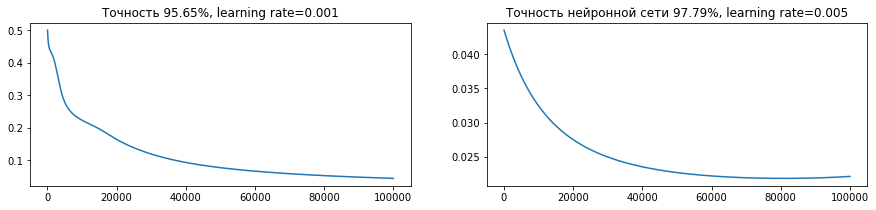

In [6]:
draw_graphs(neurons_in_layers=[4])

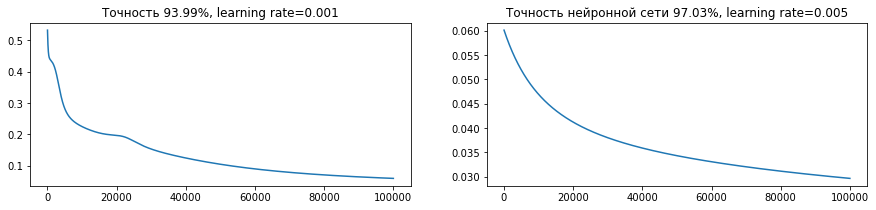

In [7]:
draw_graphs(neurons_in_layers=[5])

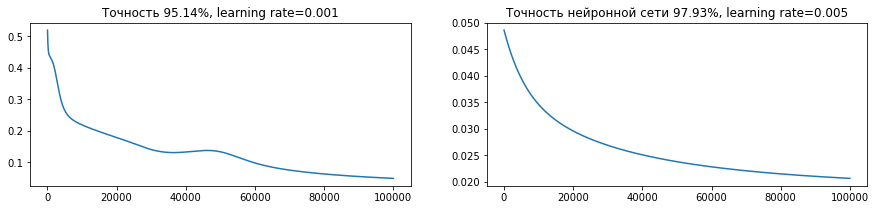

In [8]:
draw_graphs(neurons_in_layers=[7])

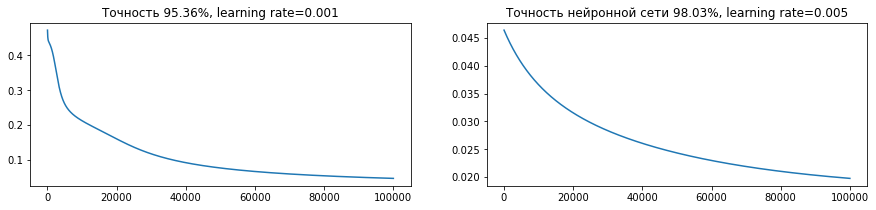

In [9]:
draw_graphs(neurons_in_layers=[10])

Если увеличить скорость обучения, то ошибка чаще изменяется более плавно, а высокая точность достгиается быстрее. Не видно зависимоти точности сети от количества нейронов в слое. Посмотрим на варианты с несколькими слоями.

C:\Users\PROFES~1\AppData\Local\Temp/ipykernel_7556/1638923736.py:23: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-x))


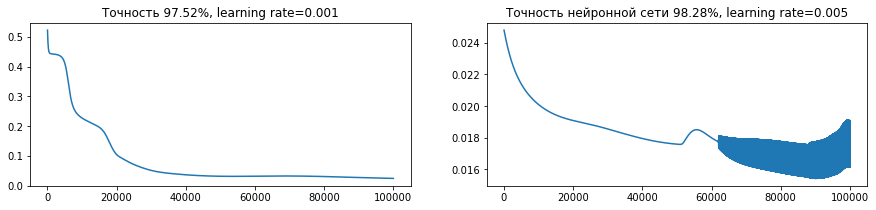

In [10]:
draw_graphs(neurons_in_layers=[5,3])

Хороший результат. Посмотрим что будет на большем количестве итераций:

C:\Users\PROFES~1\AppData\Local\Temp/ipykernel_7556/1638923736.py:23: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-x))


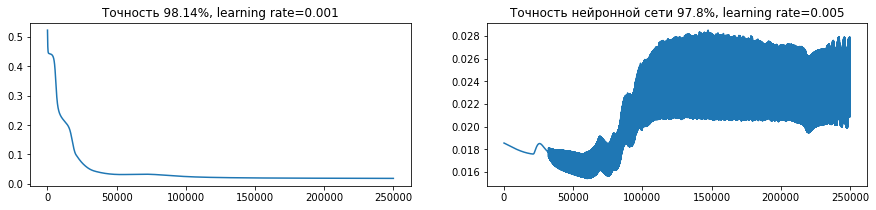

In [11]:
draw_graphs(neurons_in_layers=[5,3], epochs=250000)

На меньшей скорости ошибка продолжает незначительно уменьшаться. Теперь посмотрим на сети из 3 слоёв:

C:\Users\PROFES~1\AppData\Local\Temp/ipykernel_7556/1638923736.py:23: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-x))


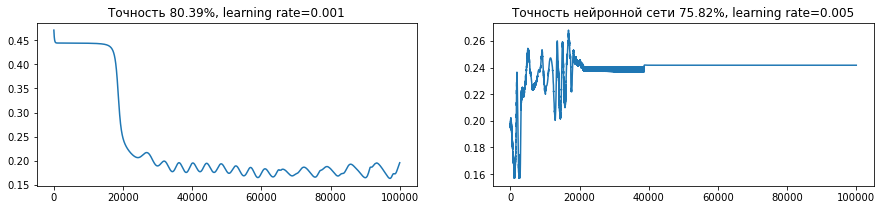

In [12]:
draw_graphs(neurons_in_layers=[3,5,3])

C:\Users\PROFES~1\AppData\Local\Temp/ipykernel_7556/1638923736.py:23: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-x))


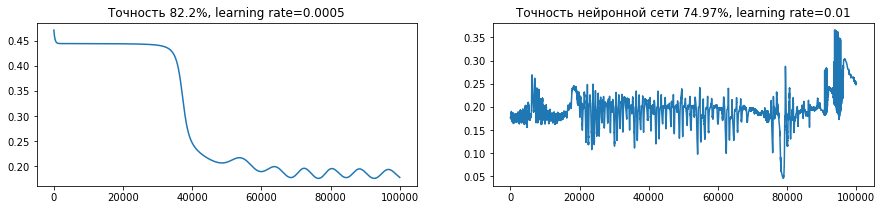

In [13]:
draw_graphs(neurons_in_layers=[3,5,3], lr1=0.0005, lr2=0.01)

C:\Users\PROFES~1\AppData\Local\Temp/ipykernel_7556/1638923736.py:23: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-x))


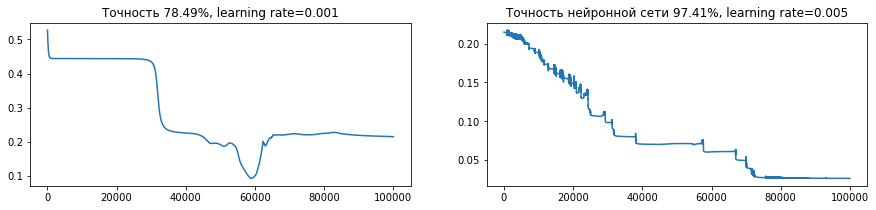

In [14]:
draw_graphs(neurons_in_layers=[7,5,3])

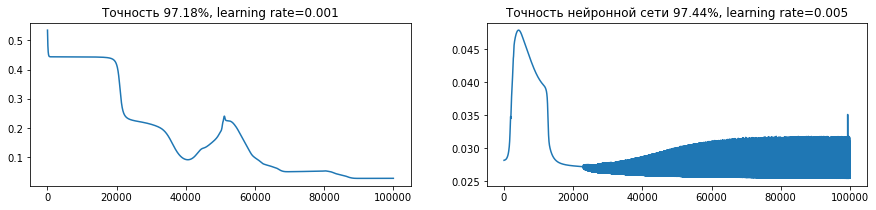

In [15]:
draw_graphs(neurons_in_layers=[3,5,7])

Некоторые варианты многослойных сетей дают хороший результат. Для нашей простой задачи достаточно несложной сетки из одного слоя, если дать достаточное количество итераций. Чем сложнее сеть, тем результат непредсказуемее. 